In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import preprocessing 

# Trend by Station

In [3]:
w = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'] 
Store_beg = 100
Store_end = 160
data = pd.read_csv('Store'+str(Store_beg)+'-'+str(Store_end)+'_item.csv')
data.head()

,StoreKey,BusinessDate,Holiday,FullHour,HalfHour,QuarterHour,CheckNum,ProductKey,NormalDateTime,CookingDateTime,BumpedDateTime,StationName,TicketTime,CookTime,OrderTime,SentTime,TotalItem,ItemAtStation
0,100,2019-04-01 00:00:00,0,11,11.0,11.00,7,3474,2019-04-01 11:09:32.000,2019-04-01 11:09:44.000,2019-04-01 11:19:07.000,SAUTE,575,563,579,666,7,1
1,100,2019-04-01 00:00:00,0,11,11.0,11.00,7,7222,2019-04-01 11:09:29.000,2019-04-01 11:09:44.000,2019-04-01 11:11:47.000,PASTA,138,123,139,669,7,1
2,100,2019-04-01 00:00:00,0,11,11.0,11.00,12,7836,2019-04-01 11:15:07.000,2019-04-01 11:15:13.000,2019-04-01 11:22:23.000,APPS,436,430,726,333,8,1
3,100,2019-04-01 00:00:00,0,11,11.0,11.25,14,7200,2019-04-01 11:21:58.000,2019-04-01 11:22:38.000,2019-04-01 11:30:33.000,GRILL,515,475,516,638,7,1
4,100,2019-04-01 00:00:00,0,11,11.0,11.25,18,23132,2019-04-01 11:27:17.000,2019-04-01 11:27:52.000,2019-04-01 11:36:13.000,SANDWICH,536,501,646,568,11,1


In [4]:
data.loc[:,'BusinessDate'] = pd.to_datetime(data.loc[:,'BusinessDate'])
data.loc[:,'NormalDateTime'] = pd.to_datetime(data.loc[:,'NormalDateTime'])
data = data.drop(columns=['NormalDateTime','CookingDateTime','BumpedDateTime'])

In [5]:
data['ToSentRatio'] = data['TicketTime']/data['SentTime']
data['CookTime'] = data['CookTime']/60
data['TicketTime'] = data['TicketTime']/60
data['OrderTime'] = data['OrderTime']/60

In [8]:
data.columns=['StoreKey', 'BusinessDate', 'Holiday', 'Hour', 'HalfHour',
       'QuarterHour', 'CheckNum', 'ProductKey', 'StationName', 'TicketTime',
       'CookTime', 'OrderTime', 'SentTime', 'TotalItem', 'ItemAtStation',
       'ToSentRatio']

# Average Item Time at Station

In [9]:
data['Ratio'] = data['ToSentRatio']*100
station = data.groupby(['StationName','ItemAtStation','Holiday'])[['OrderTime','CookTime','TicketTime','Ratio']].median().reset_index()

In [10]:
station = station.merge(right=data.groupby(['StationName','ItemAtStation','Holiday'])['ProductKey'].count().reset_index(),how='left',on=['StationName','ItemAtStation','Holiday'])
station.columns=['StationName','ItemAtStation','Holiday','OrderTime','CookTime','TicketTime','Ratio','Count']

In [11]:
s = data['StationName'].value_counts().index

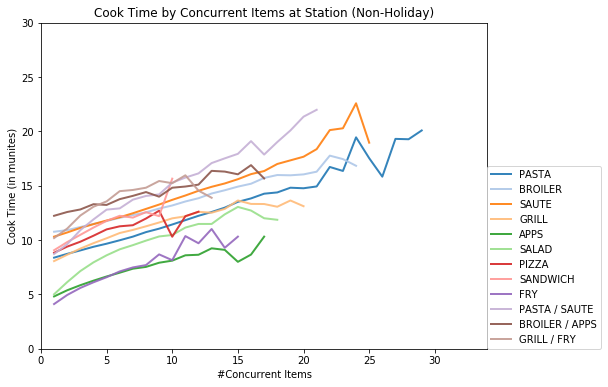

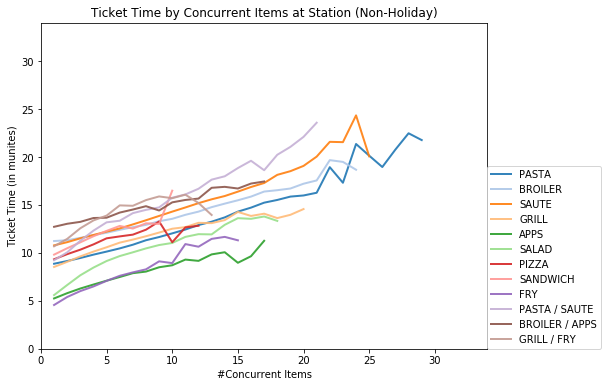

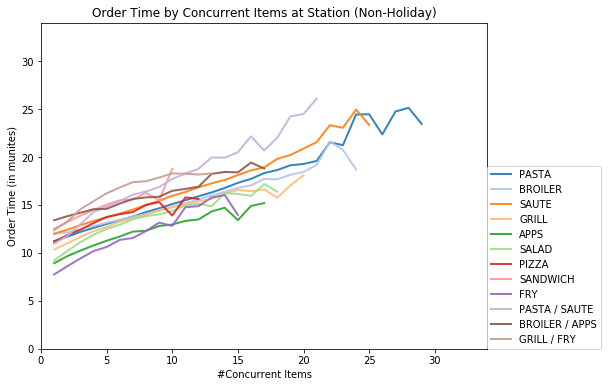

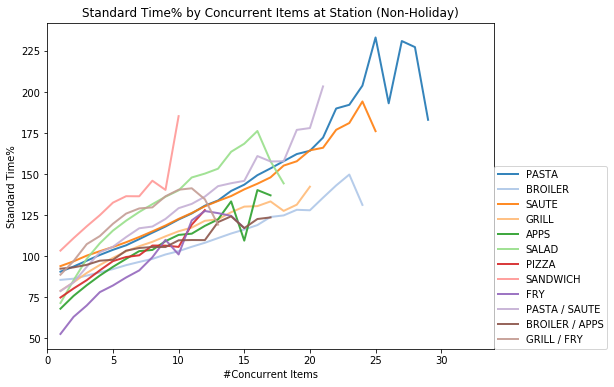

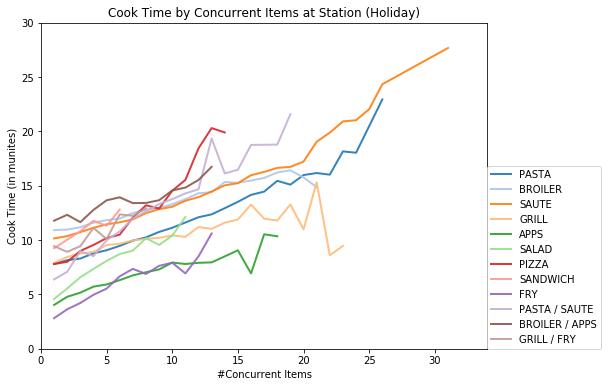

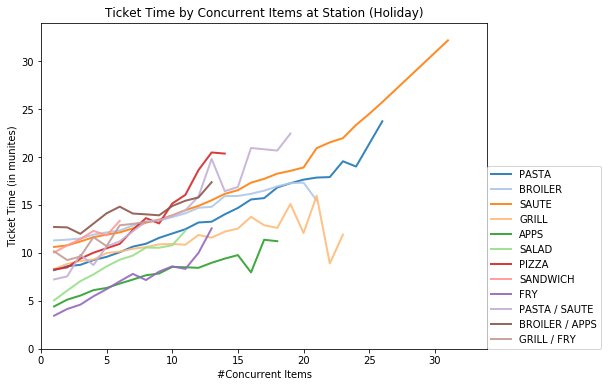

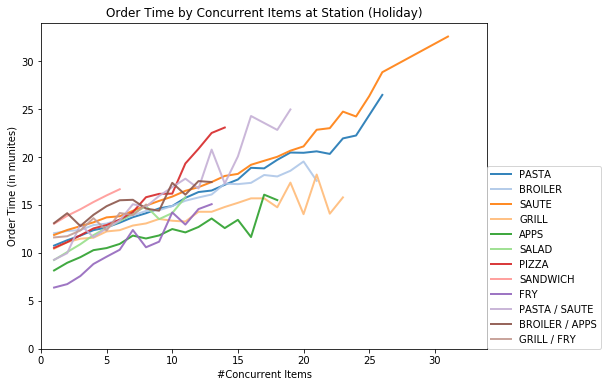

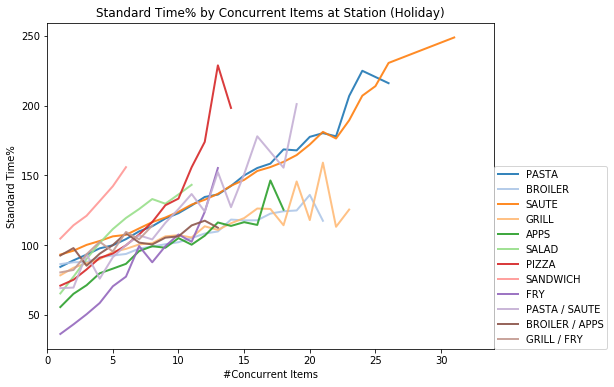

In [12]:
palatte = plt.get_cmap('tab20')
for j in [0,1]:
    for h in ['CookTime','TicketTime','OrderTime','Ratio']:
        plt.figure(figsize=(8,6))
        plt.xlim(0,34)
        for i in range(len(s)): 
            d = station[(station['Holiday']==j)&(station['StationName']==s[i])&(station['Count']>30)]
            plt.plot(d['ItemAtStation'],d[h],linewidth=2,alpha = 0.9,color=palatte(i),label=s[i])
        plt.xlabel('#Concurrent Items')
        plt.legend(loc=(1,0))
        if h == 'CookTime':
            plt.ylabel('Cook Time (in munites)')
            plt.ylim(0,30)
            if j == 0:
                plt.title('Cook Time by Concurrent Items at Station (Non-Holiday)')
            else: 
                plt.title('Cook Time by Concurrent Items at Station (Holiday)')
        elif h == 'TicketTime':
            plt.ylabel('Ticket Time (in munites)')
            plt.ylim(0,34)
            if j == 0:
                plt.title('Ticket Time by Concurrent Items at Station (Non-Holiday)')
            else: 
                plt.title('Ticket Time by Concurrent Items at Station (Holiday)')
        elif h=='OrderTime': 
            plt.ylabel('Order Time (in munites)')
            plt.ylim(0,34)
            if j == 0:
                plt.title('Order Time by Concurrent Items at Station (Non-Holiday)')
            else: 
                plt.title('Order Time by Concurrent Items at Station (Holiday)')
        else: 
            plt.ylabel('Standard Time%')
            if j == 0:
                plt.title('Standard Time% by Concurrent Items at Station (Non-Holiday)')
            else: 
                plt.title('Standard Time% by Concurrent Items at Station (Holiday)')

# Merge Labor Hrs per Category

In [13]:
#Merge Labor
labor = pd.read_csv('labor_20180103-20190711.csv')
labor = labor[(labor['StoreKey']>=Store_beg)&(labor['StoreKey']<=Store_end)]
#Specify Variable Type for Date Time Variable
labor.loc[:,'BusinessDate'] = pd.to_datetime(labor.loc[:,'BusinessDate'])

#Clean Hour Description
labor['Hour'] = np.where(labor['HourDescription'].str.contains('PM'), labor['HourDescription'].str.slice(0,2).str.replace(' ','').astype('int')+12, labor['HourDescription'].str.slice(0,2).str.replace(' ','').astype('int'))
labor['Hour'] = np.where(labor['Hour']==12,0,labor['Hour'])
labor['Hour'] = np.where(labor['Hour']==24,12,labor['Hour'])
labor.columns= ['BusinessDate','StoreKey', 'LaborCategory','HourDescription','ActualLaborHrs','Hour']
labor.head()

,BusinessDate,StoreKey,LaborCategory,HourDescription,ActualLaborHrs,Hour
17720,2018-06-26,100,Prep,1 AM,0.22,1
17721,2018-06-26,100,Dishwasher,1 AM,1.67,1
17722,2018-06-26,100,Bakery,1 AM,0.15,1
17723,2018-06-26,100,Bar,1 AM,0.50,1
17724,2018-06-26,100,Cook,1 PM,7.40,13


In [14]:
labor['LaborCategory'].unique()

array(['Prep', 'Dishwasher', 'Bakery', 'Bar', 'Cook', 'Busser',
       'Front Desk', 'Napkin', 'Runner', 'Server', 'OST', 'Management',
       'To Go', 'IT Prep', 'KM Support', 'Steward', 'IT Cook', 'Expo',
       'Cleaner', 'IT Serv', 'Maintenance', 'IT Bake', 'Lead Trainer',
       'IT FD', 'IT Dish', 'Breaker', 'IT Bus', 'IT SAT', 'IT Steward',
       'IT Bar', 'IT Expo/FDC', 'NRO Prep'], dtype=object)

In [15]:
labor = labor[labor['LaborCategory'].isin(['Prep','Cook','Runner','Server','Expo','Bar'])] 

In [16]:
#Merge Each Labor Category into data
labor_cat = []
for i in labor['LaborCategory'].unique(): 
    r = labor[labor['LaborCategory'] == i][['StoreKey','BusinessDate','Hour','ActualLaborHrs']]
    r.columns = ['StoreKey','BusinessDate','Hour','LaborHrs_'+i]
    data = data.merge(right = r, how = 'left', on = ['StoreKey','BusinessDate','Hour'])
    data['LaborHrs_'+i] = np.where(pd.isna(data['LaborHrs_'+i]),0,data['LaborHrs_'+i])
    labor_cat.append('LaborHrs_'+i)
    print(i)
    del r
del labor

Prep
Bar
Cook
Runner
Server
Expo


In [17]:
data.head()

,StoreKey,BusinessDate,Holiday,Hour,HalfHour,QuarterHour,CheckNum,ProductKey,StationName,TicketTime,...,TotalItem,ItemAtStation,ToSentRatio,Ratio,LaborHrs_Prep,LaborHrs_Bar,LaborHrs_Cook,LaborHrs_Runner,LaborHrs_Server,LaborHrs_Expo
0,100,2019-04-01,0,11,11.0,11.00,7,3474,SAUTE,9.583333,...,7,1,0.863363,86.336336,5.0,1.0,7.0,1.45,10.12,0.0
1,100,2019-04-01,0,11,11.0,11.00,7,7222,PASTA,2.300000,...,7,1,0.206278,20.627803,5.0,1.0,7.0,1.45,10.12,0.0
2,100,2019-04-01,0,11,11.0,11.00,12,7836,APPS,7.266667,...,8,1,1.309309,130.930931,5.0,1.0,7.0,1.45,10.12,0.0
3,100,2019-04-01,0,11,11.0,11.25,14,7200,GRILL,8.583333,...,7,1,0.807210,80.721003,5.0,1.0,7.0,1.45,10.12,0.0
4,100,2019-04-01,0,11,11.0,11.25,18,23132,SANDWICH,8.933333,...,11,1,0.943662,94.366197,5.0,1.0,7.0,1.45,10.12,0.0


# Store Clustering based on Maximum Labor Hours

In [26]:
#For every store, get the 90th percentile of Labor in selected categories. 
#Stores are clustered based on 90th percentile of Labor to reflect relative size of stores. 
Store = data.drop(columns=['BusinessDate','Hour','Holiday','CheckNum','ProductKey','StationName','TicketTime','CookTime','OrderTime','ItemAtStation']).groupby(['StoreKey']).agg(lambda x: np.percentile(x,90))

In [27]:
#Store['LaborHrs_Cook'] = Store['LaborHrs_Cook']+Store['LaborHrs_IT Cook']
#Store['LaborHrs_Prep'] = Store['LaborHrs_Prep']+Store['LaborHrs_IT Prep']
#Store['LaborHrs_Server'] = Store['LaborHrs_Prep']+Store['LaborHrs_IT Serv']
Store = Store[['LaborHrs_Cook','LaborHrs_Prep','LaborHrs_Server']]

In [28]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
Store_scaled = preprocessing.scale(Store) 
#Set Number of Clusters
n1= 6
kmeans = KMeans(n_clusters=n1,random_state=0).fit(Store_scaled)
#Retrieve Cluster Result and Store in column 'Class' 
Store['Class'] = None
for i in range(n1):
    Store['Class'] = np.where(kmeans.labels_==i,i,Store['Class'])
Store['Class']=Store['Class'].astype('object') 

In [29]:
#Store = Store.reset_index()

In [30]:
Store.groupby(['Class']).mean()

,LaborHrs_Cook,LaborHrs_Prep,LaborHrs_Server
Class,,,
0,10.485000,4.885000,13.215000
1,13.916000,5.768000,22.734667
2,12.250000,5.963529,18.533529
3,12.702500,4.863750,18.660000
4,13.626429,6.896429,20.904286
5,15.984000,6.974000,22.798000


In [23]:
Store[Store['Class']==5]

,LaborHrs_Cook,LaborHrs_Prep,LaborHrs_Server,Class
StoreKey,,,,
100,15.00,7.00,22.17,5
135,15.00,7.87,22.00,5
137,16.00,7.00,23.00,5
141,17.92,6.00,24.82,5
143,16.00,7.00,22.00,5


In [31]:
#plt_data = data[data['StoreKey'].isin([107,147,155])]
plt_data = data[data['StoreKey'].isin([100,111,113,125,128,137,141,143,146,150])]
plt_data['L'] = plt_data['LaborHrs_Cook'].astype('str')+'  '+\
plt_data['LaborHrs_Prep'].astype('str')+'  '+\
plt_data['LaborHrs_Server'].astype('str')

C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
plt_data['L'].value_counts()

16.0  3.0  22.0      3894
12.0  2.0  18.0      2823
15.0  2.0  22.0      2725
16.0  3.0  23.0      2722
12.0  2.0  22.0      2601
9.0  2.0  15.0       2433
8.0  2.0  14.0       2418
11.0  2.0  17.0      2388
14.0  2.0  22.0      2356
9.0  1.0  16.0       2298
14.0  3.0  22.0      2156
15.0  3.0  22.0      2144
13.0  2.0  22.0      2086
7.0  1.0  11.0       2080
7.0  5.0  12.0       1813
16.0  3.0  21.0      1708
8.0  2.0  13.0       1690
14.0  2.0  24.0      1634
11.0  1.0  16.0      1621
13.0  2.0  16.0      1583
10.0  2.0  15.0      1578
14.0  2.0  23.0      1503
14.0  2.0  21.0      1484
8.0  2.0  12.0       1464
7.0  6.0  11.0       1441
7.0  6.0  10.0       1438
16.0  2.0  20.0      1383
10.0  2.0  16.0      1380
10.0  1.0  16.0      1362
9.0  2.0  14.0       1356
                     ... 
6.83  2.0  12.28        1
6.0  1.48  3.72         1
5.45  1.68  9.35        1
8.8  3.48  4.55         1
8.47  1.0  10.47        1
7.0  7.0  1.28          1
8.02  1.0  7.42         1
8.2  2.07  4

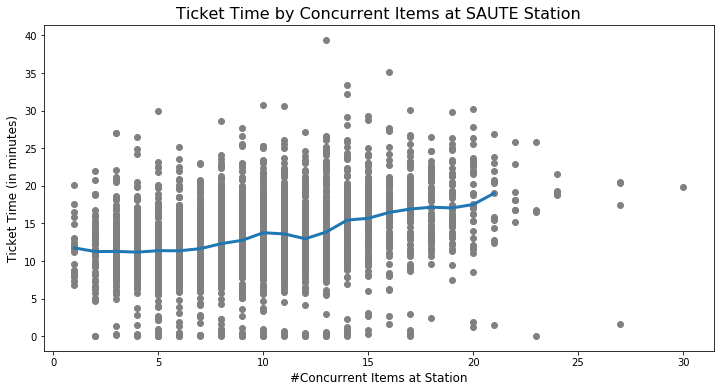

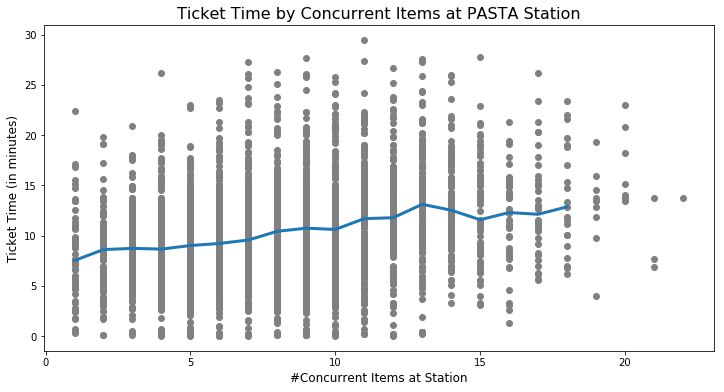

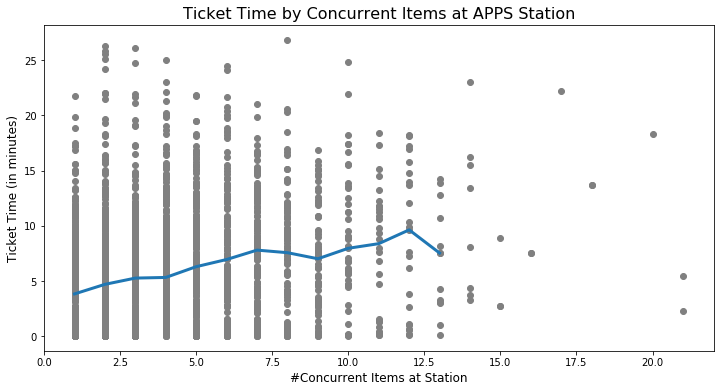

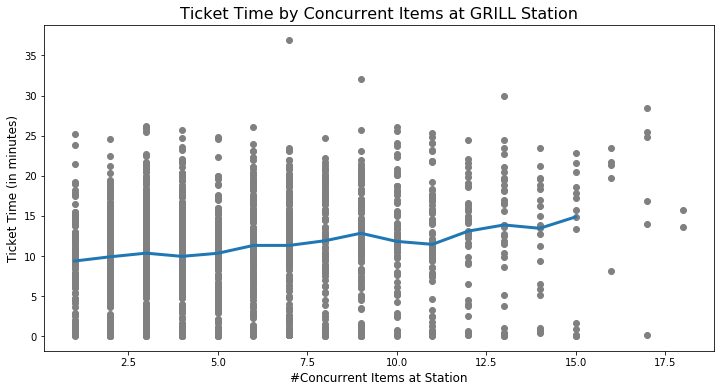

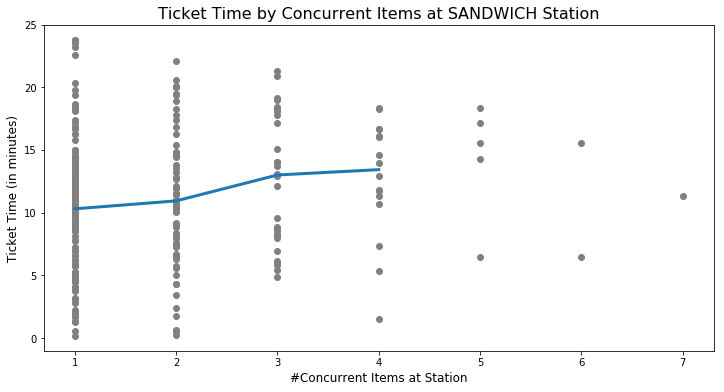

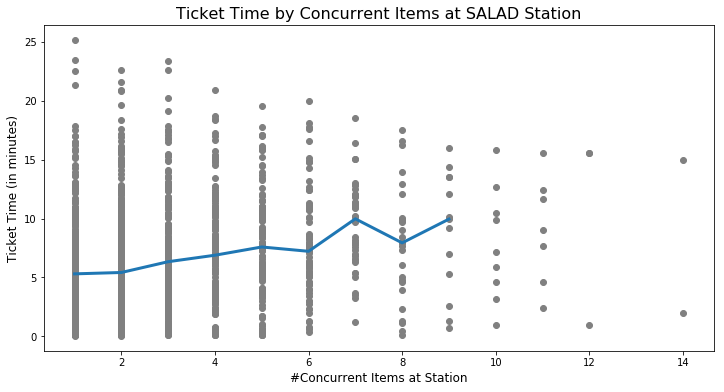

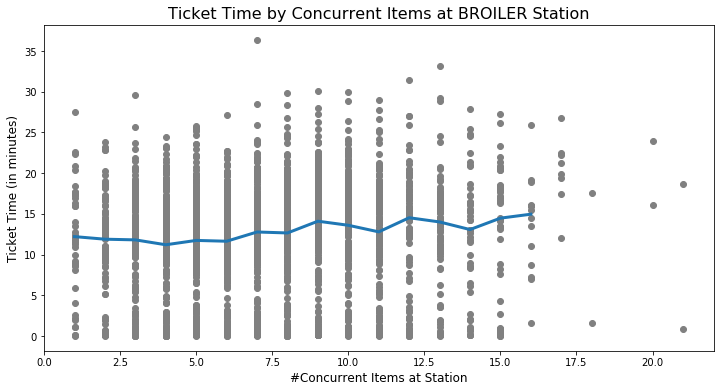

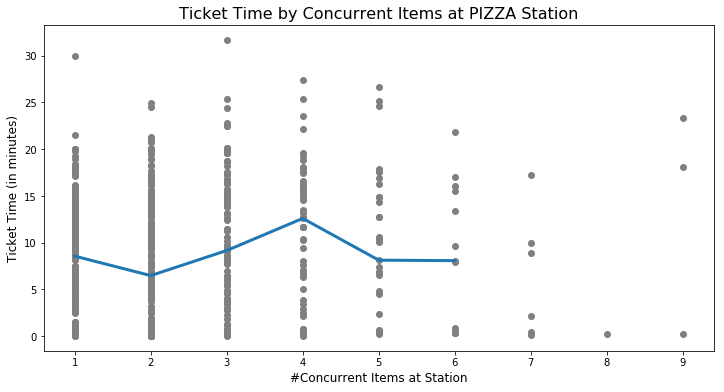

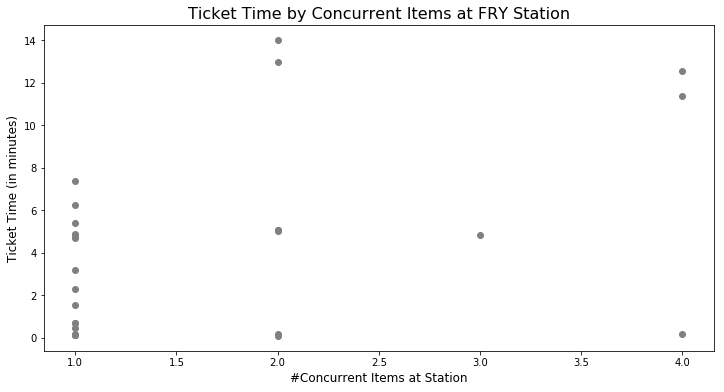

In [35]:
s = plt_data['StationName'].unique()
Cook = [15,16]
ITCook = [0]
Prep = [2,3]
Server = [21,22,23]
ITServer = [0]
for i in range(len(s)): 
    plt_data1 = plt_data[(plt_data['LaborHrs_Cook'].isin(Cook))&(plt_data['LaborHrs_Prep'].isin(Prep))\
                    &(plt_data['LaborHrs_Server'].isin(Server))&(plt_data['StationName']==s[i])]
    plt.figure(figsize=(12,6))
    plt.scatter(plt_data1['ItemAtStation'],plt_data1['TicketTime'],color='grey')
    d = plt_data1.groupby('ItemAtStation').agg({'TicketTime':['count','median']}).reset_index()
    d = d[d[('TicketTime','count')]>10]
    plt.plot(d['ItemAtStation'],d[('TicketTime','median')],linewidth=3)
    plt.xlabel('#Concurrent Items at Station',fontsize=12)
    plt.ylabel('Ticket Time (in minutes)',fontsize=12)
    plt.title('Ticket Time by Concurrent Items at '+s[i]+' Station',fontsize=16)

# Labor Efficiency - Category

In [36]:
data['LaborHrs_Cook_round'] = data['LaborHrs_Cook'].round(1)
d = data.groupby(['LaborHrs_Cook_round','StationName']).agg({'TicketTime':['count','median']}).reset_index()
data['ItemPerCook'] = data['TotalItem'] / data['LaborHrs_Cook']
d1 = data.groupby(['ItemPerCook','StationName']).agg({'TicketTime':['count','median']}).reset_index()

Text(0.5,1,'Ticket Time by Line Cook Labor Hrs')

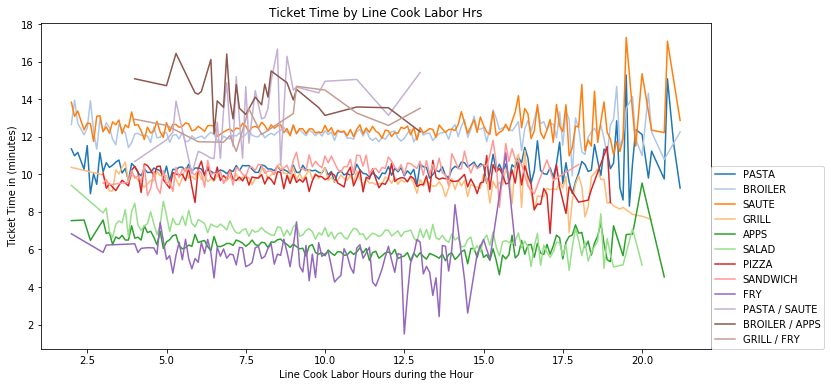

In [37]:
#Ticket TIme by Line Cook Labor Hrs
plt.figure(figsize=(12,6))
#plt.scatter(data['LaborHrs_Cook'],data['OrderTime']) 
d = d[d[('TicketTime','count')]>100]
s = data['StationName'].value_counts().index
palatte = plt.get_cmap('tab20')
for i in range(len(s)): 
    plt.plot(d.loc[d['StationName']==s[i],'LaborHrs_Cook_round'],d.loc[d['StationName']==s[i],('TicketTime','median')],color=palatte(i),label=s[i])
plt.legend(loc=(1,0))
plt.ylabel('Ticket Time in (minutes)')
plt.xlabel('Line Cook Labor Hours during the Hour')
plt.title('Ticket Time by Line Cook Labor Hrs')

Text(0.5,1,'Ticket Time by #Items per Cook')

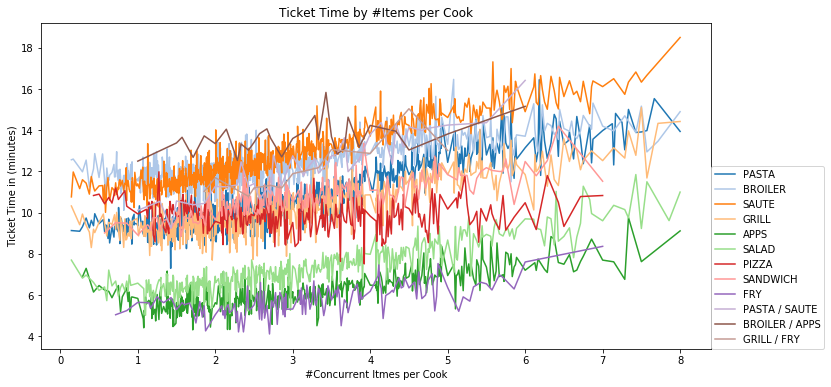

In [38]:
plt.figure(figsize=(12,6))
#plt.scatter(data['LaborHrs_Cook'],data['OrderTime']) 
d1 = d1[d1[('TicketTime','count')]>100]
s = data['StationName'].value_counts().index
palatte = plt.get_cmap('tab20')
for i in range(len(s)): 
    plt.plot(d1.loc[d1['StationName']==s[i],'ItemPerCook'],d1.loc[d1['StationName']==s[i],('TicketTime','median')],color=palatte(i),label=s[i])
plt.legend(loc=(1,0))
plt.ylabel('Ticket Time in (minutes)')
plt.xlabel('#Concurrent Itmes per Cook')
plt.title('Ticket Time by #Items per Cook')

# Merge Labor at Station

In [39]:
schedule = pd.read_csv('employee_station_20180103-20190711.csv')
schedule = schedule[(schedule['StoreKey']>=100) & (schedule['StoreKey']<=160)&(schedule['BusinessDate']>='2019-04-01')&(schedule['BusinessDate']<='2019-06-30')&\
                    (schedule['LaborCategoryName']=='Cook')]
schedule['BusinessDate'] = pd.to_datetime(schedule['BusinessDate'])
schedule['StartTime'] = pd.to_datetime(schedule['StartTime'])
schedule['EndTime'] = pd.to_datetime(schedule['EndTime'])
schedule['LocationName'] = schedule['LocationName'].str.upper()
schedule.head()

,BusinessDate,StoreKey,EmployeeKey,JobName,LaborCategoryName,StartTime,EndTime,LocationName
9713172,2019-04-01,100,73412,Line Cook1,Cook,2019-04-01 08:00:00,2019-04-01 16:00:00,PIZZAST
9713173,2019-04-01,100,113189,Line Cook1,Cook,2019-04-01 08:15:00,2019-04-01 15:00:00,SALADST
9713174,2019-04-01,100,65874,Line Cook1,Cook,2019-04-01 08:30:00,2019-04-01 13:00:00,APPCK
9713175,2019-04-01,100,193334,Line Cook1,Cook,2019-04-01 09:15:00,2019-04-01 16:00:00,GRILLCK
9713176,2019-04-01,100,62972,Line Cook1,Cook,2019-04-01 09:15:00,2019-04-01 16:00:00,BROILCK


In [40]:
schedule['LocationName'].unique()

array(['PIZZAST', 'SALADST', 'APPCK', 'GRILLCK', 'BROILCK', 'SAUTEST',
       'PASTAST', 'SALADMD', 'GRILLMD', 'APPPL', 'PASTAPL', 'SAUTEPL',
       'SALADFN', 'GRILLPL', 'BROILPL', 'KITCHFL', 'SAUTEMD', 'LINE PREP',
       'APPMD', 'SAUTEFL', 'FRYCK', 'UPKITFL', 'FRYMD', 'BROILMD',
       'FRYPL', 'PIZZAFN', 'PASTAFL', 'PASTAMD', 'SPFLOAT', 'SAND',
       'APPGRILL FLOAT', 'NO_LOCATION', 'UPSLDFN', 'PASTA SAUTE FLOAT',
       'UPPIZFN', 'UPSLDMD', 'UPPIZST', 'OVENPLT', 'OPENING SUPPORT',
       'UPSAND'], dtype=object)

In [ ]:
schedule['AtStation'] = None
schedule['StationName'] = None
labor_st = []
for j in range(100,161):
    print(j)
    Station = data.loc[data['StoreKey']==j,'StationName'].unique()
    s = [i.replace('BROILER', 'BROIL') for i in Station]
    s = [i.replace('SANDWICH', 'SAND') for i in s]
    s = [i.replace('APPS', 'APP') for i in s]
    s_clean=s
    s_sort = [i for i in s_clean if (' / ' not in i)] + [i for i in s_clean if (' / ' in i)]
    for i in s_sort:
        name = 'Labor_'+str(i)
        labor_st.append(name)
        if name not in schedule.columns: 
            schedule[name]=0
        if ' / ' not in i:
            schedule[name] = np.where((schedule['StoreKey']==j)&(schedule['LocationName'].str.contains(i)),1,schedule[name])
            schedule['StationName'] = np.where(schedule[name]==1,i,schedule['StationName'])
            schedule['AtStation'] = np.where((schedule['StoreKey']==j)&(schedule['LocationName'].str.contains(i)),1,schedule['AtStation'])
        elif ' / ' in i: #if combo station, must contain key words from both station 
            i1,i2  = i.split(' / ')
            print(i1,i2)
            schedule[name] = np.where((schedule['StoreKey']==j)&\
                                      ((schedule['LocationName'].str.contains(i1))|(schedule['LocationName'].str.contains(i2)))&\
                                       (pd.isnull(schedule['AtStation'])),1,schedule[name])
            schedule['StationName'] = np.where(schedule[name]==1,i,schedule['StationName'])
            schedule['AtStation'] = np.where((schedule['StoreKey']==j)&(((schedule['LocationName'].str.contains(i1))|(schedule['LocationName'].str.contains(i2)))&(pd.isnull(schedule['AtStation']))),1,schedule['AtStation'])

In [ ]:
schedule['StartHour'] = schedule['StartTime'].dt.hour
schedule['EndHour'] = schedule['EndTime'].dt.hour

In [ ]:
#Keep the 
schedule = schedule[schedule['AtStation']==1]

In [ ]:
schedule.to_csv('StationMapping100-160.csv')

In [ ]:
schedule = pd.read_csv('StationMapping100-160.csv',index_col = 0)
schedule['BusinessDate'] = pd.to_datetime(schedule['BusinessDate'])
schedule['StartTime'] = pd.to_datetime(schedule['StartTime'])
schedule['EndTime'] = pd.to_datetime(schedule['EndTime'])

In [ ]:
schedule['StationName'] = np.where(schedule['StationName']=='BROIL','BROILER',schedule['StationName'])
schedule['StationName'] = np.where(schedule['StationName']=='SAND','SANDWICH',schedule['StationName'])
schedule['StationName'] = np.where(schedule['StationName']=='APP','APPS',schedule['StationName'])

In [47]:
labor1 = pd.read_csv('employee_labor-20190401-20190630.csv')
labor1['BusinessDate'] = pd.to_datetime(labor1['BusinessDate'])
labor1.head()

,BusinessDate,StoreKey,Hour,EmployeeKey,JobName,LaborCategoryName,ActualLaborMinutes
0,2019-04-01,100,8,62784,Line Cook1,Cook,52
1,2019-04-01,100,9,62784,Line Cook1,Cook,60
2,2019-04-01,100,10,62784,Line Cook1,Cook,60
3,2019-04-01,100,11,62784,Line Cook1,Cook,60
4,2019-04-01,100,12,62784,Line Cook1,Cook,60


In [48]:
schedule.columns

Index(['BusinessDate', 'StoreKey', 'EmployeeKey', 'JobName',
       'LaborCategoryName', 'StartTime', 'EndTime', 'LocationName',
       'AtStation', 'StationName', 'Labor_BROIL', 'Labor_GRILL', 'Labor_PASTA',
       'Labor_SAUTE', 'Labor_SALAD', 'Labor_APP', 'Labor_SAND', 'Labor_PIZZA',
       'Labor_FRY', 'Labor_PASTA / SAUTE', 'Labor_BROIL / APP',
       'Labor_GRILL / FRY', 'StartHour', 'EndHour'],
      dtype='object')

In [49]:
labor2 = labor1.merge(right=schedule.drop(columns=['LaborCategoryName','JobName','StartTime','EndTime','AtStation']), how='left',on=['StoreKey','BusinessDate','EmployeeKey'])

In [50]:
labor2 = labor2.dropna()

In [51]:
labor2 = labor2.drop(columns=['EmployeeKey','JobName','LaborCategoryName']).groupby(['StoreKey','BusinessDate','Hour','StationName'])['ActualLaborMinutes'].sum().reset_index()

In [52]:
labor2.head()

,StoreKey,BusinessDate,Hour,StationName,ActualLaborMinutes
0,100,2019-04-01,7,SALAD,30
1,100,2019-04-01,8,APPS,30
2,100,2019-04-01,8,PASTA,52
3,100,2019-04-01,8,PIZZA,60
4,100,2019-04-01,8,SALAD,60


In [59]:
data = data.merge(right=labor2, how = 'left',on=['StoreKey','BusinessDate','Hour','StationName'])

In [60]:
data = data.fillna(0)

In [61]:
data.head()

,StoreKey,BusinessDate,Holiday,Hour,HalfHour,QuarterHour,CheckNum,ProductKey,StationName,TicketTime,CookTime,OrderTime,SentTime,TotalItem,ItemAtStation,ToSentRatio,ActualLaborMinutes
0,100,2019-04-01,0,11,11.0,11.00,7,3474,SAUTE,9.583333,9.383333,9.650000,666,7,1,0.863363,60.0
1,100,2019-04-01,0,11,11.0,11.00,7,7222,PASTA,2.300000,2.050000,2.316667,669,7,1,0.206278,60.0
2,100,2019-04-01,0,11,11.0,11.00,12,7836,APPS,7.266667,7.166667,12.100000,333,8,1,1.309309,60.0
3,100,2019-04-01,0,11,11.0,11.25,14,7200,GRILL,8.583333,7.916667,8.600000,638,7,1,0.807210,60.0
4,100,2019-04-01,0,11,11.0,11.25,18,23132,SANDWICH,8.933333,8.350000,10.766667,568,11,1,0.943662,0.0


In [62]:
data['ActualLaborHours'] = (data['ActualLaborMinutes']/60).round(1)

In [63]:
data['ToSentRatio'] = data['TicketTime']/data['SentTime']

In [67]:
d1 = data[data['Holiday']==0].groupby(['StationName','ActualLaborMinutes']).agg({'OrderTime':['median','count']}).reset_index().sort_values(by=['StationName','ActualLaborMinutes'])
d2 = data[data['Holiday']==1].groupby(['StationName','ActualLaborMinutes']).agg({'OrderTime':['median','count']}).reset_index().sort_values(by=['StationName','ActualLaborMinutes'])

Text(0.5,1,'Order Time by Labor at Station')

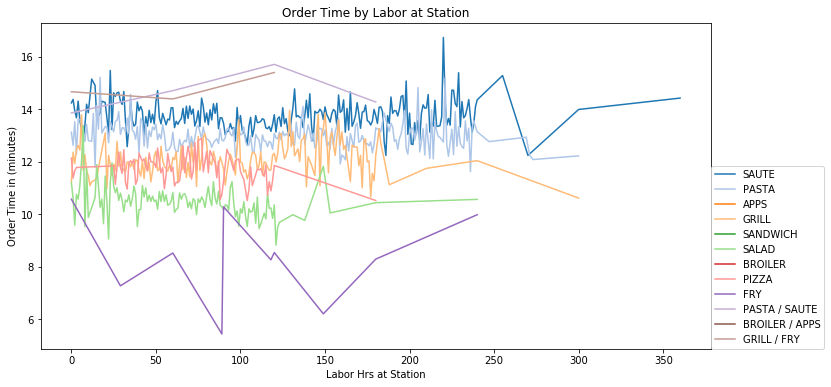

In [75]:
plt.figure(figsize=(12,6))
#plt.scatter(data['LaborHrs_Cook'],data['OrderTime']) 
d1 = d1[d1[('OrderTime','count')]>200]
s = data['StationName'].value_counts().index
palatte = plt.get_cmap('tab20')
for i in range(len(s)): 
    plt.plot(d1.loc[d1['StationName']==s[i],'ActualLaborMinutes'],d1.loc[d1['StationName']==s[i],('OrderTime','median')],color=palatte(i),label=s[i])
plt.legend(loc=(1,0))
plt.ylabel('Order Time in (minutes)')
plt.xlabel('Labor Hrs at Station')
plt.title('Order Time by Labor at Station')

Text(0.5,1,'Order Time by Labor at Station')

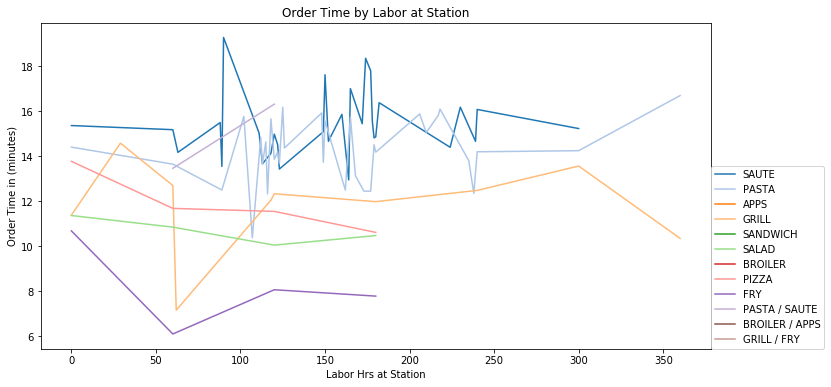

In [76]:
plt.figure(figsize=(12,6))
#plt.scatter(data['LaborHrs_Cook'],data['OrderTime']) 
d2 = d2[d2[('OrderTime','count')]>200]
s = pd.Series(data['StationName'].unique())
palatte = plt.get_cmap('tab20')
for i in range(len(s)): 
    plt.plot(d2.loc[d2['StationName']==s[i],'ActualLaborMinutes'],d2.loc[d2['StationName']==s[i],('OrderTime','median')],color=palatte(i),label=s[i])
plt.legend(loc=(1,0))
plt.ylabel('Order Time in (minutes)')
plt.xlabel('Labor Hrs at Station')
plt.title('Order Time by Labor at Station')

In [24]:
data['ItemPerLabor'] = (data['ItemAtStation'] / data['ActualLaborMinutes']*60).round(1)

In [71]:
data[(data['ItemPerLabor']>100)&(data['ActualLaborMinutes']>0)]

,StoreKey,BusinessDate,Holiday,Hour,HalfHour,QuarterHour,CheckNum,ProductKey,StationName,TicketTime,...,LaborHrs_Runner,LaborHrs_Server,LaborHrs_Expo,DayOfWeek,DayOfWeekName,LaborHrs_Cook_round,ItemPerCook,ActualLaborMinutes,ActualLaborHours,ItemPerLabor
49629,100,2019-05-12,1,15,15.5,15.75,590,25917,PIZZA,0.800000,...,5.10,21.02,0.0,6,Sunday,17.0,2.701116,2.0,0.0,120.0
67737,100,2019-05-23,0,15,15.0,15.25,309,7606,SALAD,3.766667,...,2.00,16.05,0.0,3,Thursday,9.2,1.409978,2.0,0.0,120.0
73459,100,2019-05-12,1,15,15.5,15.50,575,30674,PIZZA,14.466667,...,5.10,21.02,0.0,6,Sunday,17.0,3.347035,2.0,0.0,120.0
73566,100,2019-05-12,1,15,15.5,15.75,609,25917,PIZZA,3.333333,...,5.10,21.02,0.0,6,Sunday,17.0,2.994715,2.0,0.0,150.0
127941,101,2019-04-01,0,15,15.5,15.75,283,7514,PASTA,23.183333,...,1.00,8.72,0.0,0,Monday,3.1,2.272727,1.0,0.0,120.0
142820,101,2019-04-14,0,11,11.0,11.00,37,27895,GRILL,5.733333,...,2.05,16.57,0.0,6,Sunday,8.0,3.018868,2.0,0.0,120.0
142821,101,2019-04-14,0,11,11.0,11.00,38,3460,GRILL,2.933333,...,2.05,16.57,0.0,6,Sunday,8.0,3.899371,2.0,0.0,180.0
142828,101,2019-04-14,0,11,11.0,11.25,44,30023,GRILL,4.516667,...,2.05,16.57,0.0,6,Sunday,8.0,3.396226,2.0,0.0,120.0
142829,101,2019-04-14,0,11,11.0,11.25,46,7515,GRILL,11.150000,...,2.05,16.57,0.0,6,Sunday,8.0,3.773585,2.0,0.0,150.0
142857,101,2019-04-14,0,11,11.5,11.50,43,7200,GRILL,25.783333,...,2.05,16.57,0.0,6,Sunday,8.0,4.150943,2.0,0.0,180.0


In [41]:
d0 = data[(data['ActualLaborMinutes']>5)].groupby(['StationName','ItemPerLabor']).agg({'TicketTime':['median','count']}).reset_index().sort_values(by=['StationName','ItemPerLabor'])
#d3 = data[(data['Holiday']==0)&(data['ActualLaborMinutes']>5)].groupby(['StationName','ItemPerLabor']).agg({'TicketTime':['median','count']}).reset_index().sort_values(by=['StationName','ItemPerLabor'])
#d4 = data[(data['Holiday']==1)&(data['ActualLaborMinutes']>5)].groupby(['StationName','ItemPerLabor']).agg({'TicketTime':['median','count']}).reset_index().sort_values(by=['StationName','ItemPerLabor'])

Text(0.5,1,'Ticket Time by #Items per Cook')

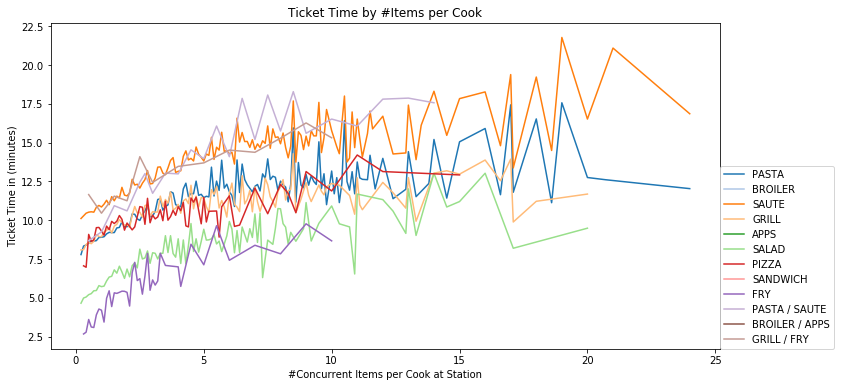

In [42]:
plt.figure(figsize=(12,6))
#plt.scatter(data['LaborHrs_Cook'],data['OrderTime']) 
d0 = d0[d0[('TicketTime','count')]>100]
d0 = d0[d0['ItemPerLabor']<28]
s = data['StationName'].value_counts().index
palatte = plt.get_cmap('tab20')
for i in range(len(s)): 
    plt.plot(d0.loc[d0['StationName']==s[i],'ItemPerLabor'],d0.loc[d0['StationName']==s[i],('TicketTime','median')],color=palatte(i),label=s[i])
plt.legend(loc=(1,0))
plt.ylabel('Ticket Time in (minutes)')
plt.xlabel('#Concurrent Items per Cook at Station')
plt.title('Ticket Time by #Items per Cook')


In [40]:
plt.figure(figsize=(12,6))
#plt.scatter(data['LaborHrs_Cook'],data['OrderTime']) 
d3 = d3[d3[('TicketTime','count')]>80]
s = data['StationName'].value_counts().index
palatte = plt.get_cmap('tab20')
for i in range(len(s)): 
    plt.plot(d3.loc[d3['StationName']==s[i],'ItemPerLabor'],d3.loc[d3['StationName']==s[i],('TicketTime','median')],color=palatte(i),label=s[i])
plt.legend(loc=(1,0))
plt.ylabel('Order Time in (minutes)')
plt.xlabel('#Concurrent Item per Cook')
plt.title('Order Time by Labor at Station for Non-Holidays')

NameError: name 'd3' is not defined

<Figure size 864x432 with 0 Axes>

Text(0.5,1,'Order Time by Labor at Station for Holidays')

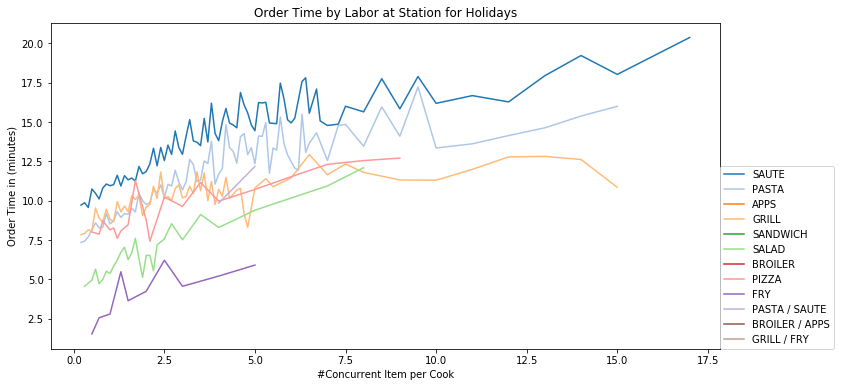

In [78]:
plt.figure(figsize=(12,6))
#plt.scatter(data['LaborHrs_Cook'],data['OrderTime']) 
d4 = d4[d4[('TicketTime','count')]>100]
s = pd.Series(data['StationName'].unique())
palatte = plt.get_cmap('tab20')
for i in range(len(s)): 
    plt.plot(d4.loc[d4['StationName']==s[i],'ItemPerLabor'],d4.loc[d4['StationName']==s[i],('TicketTime','median')],color=palatte(i),label=s[i])
plt.legend(loc=(1,0))
plt.ylabel('Order Time in (minutes)')
plt.xlabel('#Concurrent Item per Cook')
plt.title('Order Time by Labor at Station for Holidays')

In [ ]:
for store in range(100, 161,1):
    d3 = data[(data['Holiday']==0)&(data['ActualLaborMinutes']>0)&(data['StoreKey']==store)].groupby(['StationName','ItemPerLabor']).agg({'TicketTime':['median','count']}).reset_index().sort_values(by=['StationName','ItemPerLabor'])
    #d4 = data[(data['Holiday']==1)&(data['ActualLaborMinutes']>0)].groupby(['StationName','ItemPerLabor']).agg({'OrderTime':['median','count']}).reset_index().sort_values(by=['StationName','ItemPerLabor'])
    plt.figure(figsize=(12,6))
    #plt.scatter(data['LaborHrs_Cook'],data['OrderTime']) 
    d3 = d3[d3[('TicketTime','count')]>30]
    s = pd.Series(data['StationName'].unique())
    palatte = plt.get_cmap('tab20')
    for i in range(len(s)): 
        plt.plot(d3.loc[d3['StationName']==s[i],'ItemPerLabor'],d3.loc[d3['StationName']==s[i],('TicketTime','median')],color=palatte(i),label=s[i])
    plt.legend(loc=(1,0))
    plt.ylabel('Order Time in (minutes)')
    plt.xlabel('#Concurrent Item per Cook')
    plt.title('Order Time by Labor at Station - Store'+str(store))
    plt.xlim(-1,18)

In [ ]:
for store in range(100, 161,1):
    d4 = data[(data['Holiday']==1)&(data['ActualLaborMinutes']>0)&(data['StoreKey']==store)].groupby(['StationName','ItemPerLabor']).agg({'OrderTime':['median','count']}).reset_index().sort_values(by=['StationName','ItemPerLabor'])
    #d4 = data[(data['Holiday']==1)&(data['ActualLaborMinutes']>0)].groupby(['StationName','ItemPerLabor']).agg({'OrderTime':['median','count']}).reset_index().sort_values(by=['StationName','ItemPerLabor'])
    plt.figure(figsize=(12,6))
    #plt.scatter(data['LaborHrs_Cook'],data['OrderTime']) 
    d4 = d4[d4[('OrderTime','count')]>30]
    s = pd.Series(data['StationName'].unique())
    palatte = plt.get_cmap('tab20')
    for i in range(len(s)): 
        plt.plot(d4.loc[d4['StationName']==s[i],'ItemPerLabor'],d4.loc[d4['StationName']==s[i],('OrderTime','median')],color=palatte(i),label=s[i])
    plt.legend(loc=(1,0))
    plt.ylabel('Order Time in (minutes)')
    plt.xlabel('#Concurrent Item per Cook')
    plt.title('Order Time by Labor at Station - Store'+str(store))
    

# Demand Trend VS Labor Schedule Trend => Order Time as a result

In [65]:
data['DayOfWeek'] = data['BusinessDate'].dt.weekday
data['DayOfWeekName'] = data['BusinessDate'].dt.weekday_name

In [66]:
data=data[data['Hour']>=10]

In [46]:
time = data.groupby(['DayOfWeek','DayOfWeekName','Hour'])[['OrderTime','TicketTime','CookTime','TotalItem','LaborHrs_Cook']].mean().reset_index()
time['Time'] = time['DayOfWeekName'] + ' ' + time['Hour'].astype('str') + ':00'
time['Label'] = time['Hour']%2==0

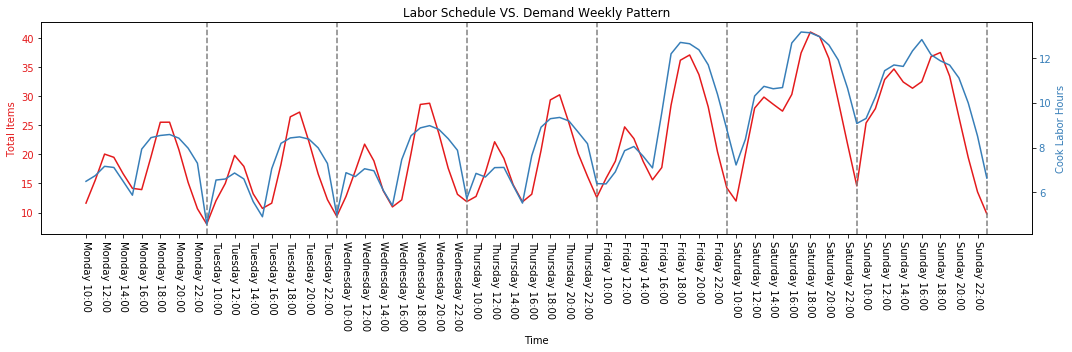

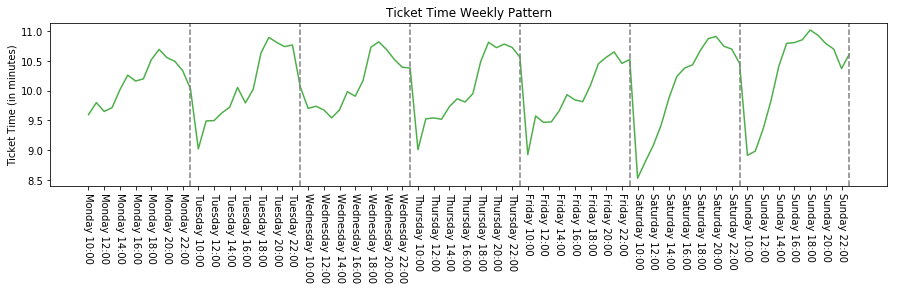

In [115]:
palatte = plt.get_cmap('Set1')
time = time.sort_values(by=['DayOfWeek','Hour'])
fig,ax1 = plt.subplots(figsize=(15,5))
ax1.set_xlabel('Time')

color1 = palatte(0)
ax1.set_ylabel('Total Items',color=color1)
ax1.plot(time['Time'],time['TotalItem'],color=color1)
ax1.tick_params(axis='y',labelcolor=color1)

ax2 = ax1.twinx()
color2 = palatte(1)
ax2.set_ylabel('Cook Labor Hours',color=color2)
ax2.plot(time['Time'],time['LaborHrs_Cook'],color=color2)
ax2.tick_params(axis='y',labelcolor=color2)

ax1.set_xticks(time.loc[time['Label'],'Time'])
ax1.set_xticklabels(time.loc[time['Label'],'Time'],rotation=270)
#plt.xticks(time.loc[time['Label'],'Time'],rotation=270)
plt.title('Labor Schedule VS. Demand Weekly Pattern')

ax1.axvline(x='Monday 23:00',linestyle='--',color = 'grey')
ax1.axvline(x='Tuesday 23:00',linestyle='--',color = 'grey')
ax1.axvline(x='Wednesday 23:00',linestyle='--',color = 'grey')
ax1.axvline(x='Thursday 23:00',linestyle='--',color = 'grey')
ax1.axvline(x='Friday 23:00',linestyle='--',color = 'grey')
ax1.axvline(x='Saturday 23:00',linestyle='--',color = 'grey',)
ax1.axvline(x='Sunday 23:00',linestyle='--',color = 'grey',)
fig.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
color3 = palatte(2)
plt.plot(time['Time'],time['TicketTime'],color=color3)
plt.xticks(time.loc[time['Label'],'Time'],rotation=270)
plt.ylabel('Ticket Time (in minutes)')
plt.title('Ticket Time Weekly Pattern')
plt.axvline(x='Monday 23:00',linestyle='--',color = 'grey')
plt.axvline(x='Tuesday 23:00',linestyle='--',color = 'grey')
plt.axvline(x='Wednesday 23:00',linestyle='--',color = 'grey')
plt.axvline(x='Thursday 23:00',linestyle='--',color = 'grey')
plt.axvline(x='Friday 23:00',linestyle='--',color = 'grey')
plt.axvline(x='Saturday 23:00',linestyle='--',color = 'grey')
plt.axvline(x='Sunday 23:00',linestyle='--',color = 'grey')

In [24]:
time1 = data[data['StationName']=='PASTA'].groupby(['DayOfWeek','DayOfWeekName','Hour'])[['OrderTime','TicketTime','CookTime','TotalItem','ActualLaborHours']].mean().reset_index()
time1['Time'] = time1['DayOfWeekName'] + ' ' + time1['Hour'].astype('str') + ':00'
time1['Label'] = time1['Hour']%2==0

In [ ]:
data.columns

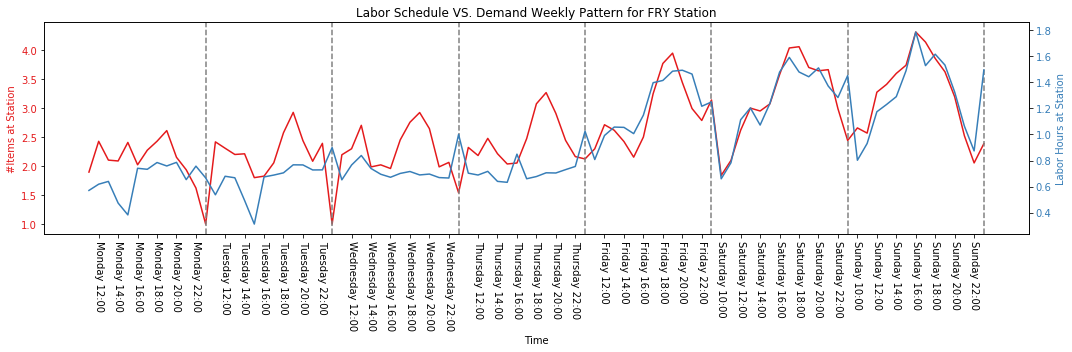

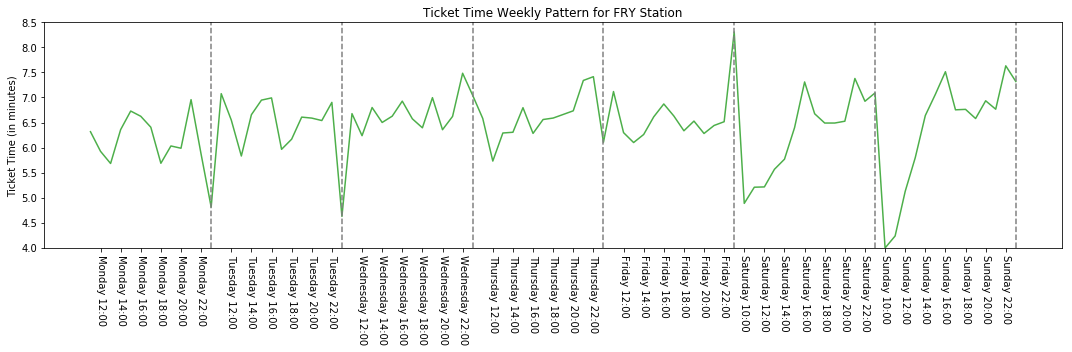

In [86]:
for i in ['FRY']:

    time1 = data[data['StationName']==i].groupby(['DayOfWeek','DayOfWeekName','Hour'])[['OrderTime','TicketTime','CookTime','ItemAtStation','ActualLaborHours']].mean().reset_index()
    time1['Time'] = time1['DayOfWeekName'] + ' ' + time1['Hour'].astype('str') + ':00'
    time1['Label'] = time1['Hour']%2==0

    # pasta broiler saute
    palatte = plt.get_cmap('Set1')
    time1 = time1.sort_values(by=['DayOfWeek','Hour'])
    fig,ax1 = plt.subplots(figsize=(15,5))
    ax1.set_xlabel('Time')

    color1 = palatte(0)
    ax1.set_ylabel('#Items at Station',color=color1)
    ax1.plot(time1['Time'],time1['ItemAtStation'],color=color1)
    ax1.tick_params(axis='y',labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = palatte(1)
    ax2.set_ylabel('Labor Hours at Station',color=color2)
    ax2.plot(time1['Time'],time1['ActualLaborHours'],color=color2)
    ax2.tick_params(axis='y',labelcolor=color2)

    ax1.set_xticks(time1.loc[time1['Label'],'Time'])
    ax1.set_xticklabels(time1.loc[time1['Label'],'Time'],rotation=270)
    #plt.xticks(time.loc[time['Label'],'Time'],rotation=270)
    plt.title('Labor Schedule VS. Demand Weekly Pattern for '+i+' Station')

    ax1.axvline(x='Monday 23:00',linestyle='--',color = 'grey')
    ax1.axvline(x='Tuesday 23:00',linestyle='--',color = 'grey')
    ax1.axvline(x='Wednesday 23:00',linestyle='--',color = 'grey')
    ax1.axvline(x='Thursday 23:00',linestyle='--',color = 'grey')
    ax1.axvline(x='Friday 23:00',linestyle='--',color = 'grey')
    ax1.axvline(x='Saturday 23:00',linestyle='--',color = 'grey',)
    ax1.axvline(x='Sunday 23:00',linestyle='--',color = 'grey',)
    fig.tight_layout()
    plt.show()

    plt.figure(figsize=(15,5))
    color3 = palatte(2)
    plt.plot(time1['Time'],time1['TicketTime'],color=color3)
    plt.xticks(time1.loc[time1['Label'],'Time'],rotation=270)
    plt.ylabel('Ticket Time (in minutes)')
    plt.title('Ticket Time Weekly Pattern for '+i+' Station')
    plt.axvline(x='Monday 23:00',linestyle='--',color = 'grey')
    plt.axvline(x='Tuesday 23:00',linestyle='--',color = 'grey')
    plt.axvline(x='Wednesday 23:00',linestyle='--',color = 'grey')
    plt.axvline(x='Thursday 23:00',linestyle='--',color = 'grey')
    plt.axvline(x='Friday 23:00',linestyle='--',color = 'grey')
    plt.axvline(x='Saturday 23:00',linestyle='--',color = 'grey')
    plt.axvline(x='Sunday 23:00',linestyle='--',color = 'grey')
    plt.ylim(4,8.5)
    plt.tight_layout()
